<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-\amily:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Regularization
              
</p>
</div>

Data Science Cohort Live NYC Nov 2022
<p>Phase 3: Topic 24</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>

# Objectives
- **Explain** the bias-variance tradeoff and the correlative notions of underfit and overfit models
- Explain the notion of "validation data"
- Use the algorithm of cross-validation (with `sklearn`)
- Explain the concept of regularization
- Use Lasso and Ridge regularization in model design

# The Bias-Variance Tradeoff

We can break up how the model makes mistakes (the error) by saying there are three parts:

- Error inherent in the data (noise): **irreducible error**
- Error from not capturing signal (too simple): **bias**
- Error from "modeling noise", i.e. capturing patterns in the data that don't generalize well (too complex): **variance**

### Bias

**High-bias** algorithms tend to be less complex, with simple or rigid underlying structure.

![](images/noisy-sine-linear.png)

+ They train models that are consistent, but inaccurate on average.
+ These include linear or parametric algorithms such as regression and naive Bayes.
+ The following sorts of difficulties could lead to high bias:
  - We did not include the correct predictors
  - We did not take interactions into account
  - We missed a non-linear (polynomial) relationship

      
High-bias models are generally **underfit**: The models have not picked up enough of the signal in the data. And so even though they may be consistent, they don't perform particularly well on the initial data, and so they will be consistently inaccurate.

### Variance

On the other hand, **high-variance** algorithms tend to be more complex, with flexible underlying structure.

<img src = "images/noisy-sine-decision-tree.png"  width = 800/>


+ They train models that are accurate on average, but inconsistent.
+ These include non-linear or non-parametric algorithms such as decision trees and nearest-neighbor models.
+ The following sorts of difficulties could lead to high variance:
  - We included an unreasonably large number of predictors;
  - We created new features by squaring and cubing each feature.

High variance models are **overfit**: The models have picked up on the noise as well as the signal in the data. And so even though they may perform well on the initial data, they will be inconsistently accurate on new data.

In [3]:
### Balancing Bias and Variance

While we build our models, we have to keep this relationship in mind.  If we build complex models, we risk overfitting our models.  Their predictions will vary greatly when introduced to new data.  If our models are too simple, the predictions as a whole will be inaccurate.   

![](images/noisy-sine-third-order-polynomial.png)

Bias: 
- when model not complex enough
- feature space not adequately rich enough to explain target

Variance: 

- model/weights: large fluctuations about true model given different train sets

- High $ \mathrm{Var}[{w}] $ over realization of training sets

- High fluctuation in MAE over test sets.

The bulls-eye diagrams of fitting model to different training set realizations:
<center><img src = "images/biasvar_bullseye.png" width = 400/></center>

Each dot is a model:
- Bulls-eye: the *true* model (generating mean of $y$ given $X$ in the population) 
- Each dot: models trained on different samples.

**Our goal**: lowering bias and variance in training predictive models

but the two often at odds.

#### Multicollinearity
Have to grapple with these issues when constructing linear models with multicollinear features

We talked about this way back. But how does it increase $Var[{w}]$?

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

WHO_data = pd.read_csv("data/WHO_life.csv")
X_WHO = WHO_data.drop(columns = ["Life expectancy "])
y = WHO_data["Life expectancy "]

In [5]:
X_WHO.head()

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Many features from WHO dataset:

Regressing to find weights life expectancy

In [6]:
X_WHO.columns

Index(['Country', 'Year', 'Status', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

But let's take a look at a few of these and their correlations:

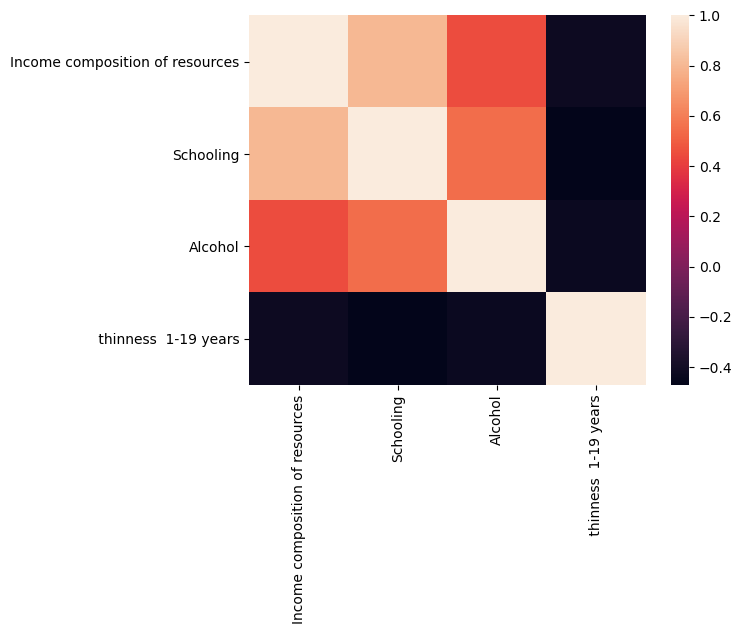

In [7]:
col_selector = ['Income composition of resources', 'Schooling','Alcohol', ' thinness  1-19 years']
subsetX = X_WHO[col_selector]
sns.heatmap(subsetX.corr())
plt.show()

Let's focus on Schooling and income composite resources (ICR):

$$ Life= w_1*Alcohol + w_2*Polio + w_3*Schooling + w_4*Measles + w_5*ICR + ... $$

Correlation is very high!

In [8]:
col_selector = ['Income composition of resources', 'Schooling']
X_WHO[col_selector].corr()

,Income composition of resources,Schooling
Income composition of resources,1.000000,0.800092
Schooling,0.800092,1.000000


Our regression: 
- Y = life expectancy

$$ Y - \sum_{i \neq 3,5} w_i x_i = w_3 Schooling + w_5 ICR $$

- Schooling and ICR highly related:

- Implies that $w_3$ and $w_5$ introduce too much flexibility.
- Maybe could fit almost as well with just $w_3$.

- $w_3$ and $w_5$ are floppy and can become big in either direction to fit data.
- $Var[{w}]$ from $w_3$ and $w_5$ high.

Modeling data by linear model w/ multicollinear features:
- intoduces high weight variance
- unnecessary model complexity

These considerations are all nice and theoretical:
    
- how do we actually assess whether model suffers from bias / variance or both?

#### How to assess model variance: cross-validation

Could get many different training sets:
- Train weights ${w}$ for each.
- Get variance of ${w}$ 

Semi-equivalently:
- Test performance of each model on test set.
- Evaluate model performance/variance by looking at average/standard deviation of performance on test set.

Problem: 
- likely don't have this much data available to make enough independent training sets large enough to for each model to train on effectively.

#### Solution: Cross validation

So first we created our train / test split: 

- the **training set** can be used to develop models
- can assess variance of a model and average performance

<img src = "images/traintestsplit.png"  width = 800/>
<center> Splitting up training set </center>

<img src = "Images/crossval.png"  width = 800/>
<center> Splitting up training set </center>

Split up training set into folds:
- Training fold
- Validation fold

- For each iteration:
    - train a model.
    - Test on validation fold. 

- Good for estimating model performance on average
- Good for estimating model variance as well.

Effectively sampling multiple training sets:
- testing each model performance on different **validation set**.
- Good for estimating model performance on average
- Good for estimating model variance as well.


So in the end:
- Performance metrics measured on validation
- We get average performance metric across all the models for each cross validation iteration.
- Get variance of performance metric.

Note: **validation set** is part of training set:
- Not part of true test/hold-out set.

We are often trying out different model types:
- OLS with raw features
- OLS with collinear features dropped
- OLS with polynomial features
- Ridge regressor (will see later)

Idea is that we try out different model types / tune models: 
- assess variance
- assess average performance

**Use train/validation for this**: 
- for each model type: estimate model average performance and variance *across different train/validation realizations*

True and final evaluation:
- Measure performance on tuned model on the test set that has never been seen before.

<img src = "Images/cvtuningflow.png"  width = 800/>
<center> Model comparison/selection using cross-validation </center>
<center> Best model from cross-validation in test phase</center>

Roughly:
- Training data is for building the model;
- Validation data is for *tweaking* the model;
- Testing data is for evaluating the model on unseen data.

- Think of **training** data as what you study for a test
- Think of **validation** data is using a practice test (note sometimes called **dev**)
- Think of **testing** data as what you use to judge the model
    - A **holdout** set is when your test dataset is never used for training (unlike in cross-validation)

Selected best model based on:
- what worked best on the given validation folds.

**Iterative optimization of models based on the train/validation data**

Ultimately: 

- want to evaluate our best model class (found by optimizing over the validation sets) 
- on data that has neither been trained or validated on

![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)
> Image from Scikit-Learn https://scikit-learn.org/stable/modules/cross_validation.html


<img src = "Images/test_phase_afterCV.png"  width = 800/>
<center> Best model from cross-validation in test phase</center>

1. Split data into training data and a holdout test
2. Design a model
3. Evaluate how well it generalizes with **cross-validation** (only training data)
4. Determine if we should adjust model, use cross-validation to evaluate, and repeat
5. After iteratively adjusting your model, do a _final_ evaluation with the holdout test set
6. DON'T TOUCH THE MODEL!!!

Cross validation gives us a way to test statistical robustness of model performance:
- evaluate average performance
- evaluate model variance

But seeing a set of models have high variance:
- How to address this problem found in cross-validation trials?
- i.e., how do we lower the variance?

#### Ways to limit/deal with high variance.

- Get more data. With enough training data, even with floppy weights it'll get it right.

- Yeah, but often not possible/easy to get enough data for this.

- Get rid of columns that exhibit a high degree of collinearity with other columns.

- Yeah, but did we throw out some useful information for prediction? 
- ICR and schooling not the same thing.
- How many of the collinear columns should we throw away? Which ones?

Getting rid of columns like this:
- Can lower variance
- But can also increase bias in an arbitrary, non-optimal way

- Or we could come up with ways to directly limit the variance through the cost function itself.

The hope is that with this method:
- decrease variance
- without increasing bias too much

Doing this in an optimal and principled way.

Let's try this.

# Preventing Overfitting - Regularization
Again, complex models are very flexible in the patterns that they can model but this also means that they can easily find patterns that are simply statistical flukes of one particular dataset rather than patterns reflective of the underlying data-generating process.

When a model has large weights, the model is "too confident". This translates to a model with high variance which puts it in danger of overfitting!

![](images/punishing_model_metaphor.jpeg)

We need to punish large (confident) weights by contributing them to the error function

**Some Types of Regularization:**

1. Reducing the number of features
2. Increasing the amount of data
3. Popular techniques: Ridge, Lasso, Elastic Net

#### Regularization for Linear Regression

Modify our squared error loss function.

$$\large L = |{y} - X {w}|^2 + \lambda |{w}|^2 $$

with $|{w}|^2 = w_1^2 + w_2^2 + ... + w_m^2$ as sum of squares of the feature weights.

<img src = "Images/ridge_regression_geometric.png" width = 450>

Tug of war between:

Ridge cost: $ \lambda |{w}|^2 = \lambda (w_1^2 + w_2^2)  $
- L2 Regularization (Euclidean distance)

Least squares cost: $ |{y} - X{w}|^2 $
    

<img src = "Images/ridge_regression_geometric.png" width = 450>

Penalizes large weights: 
- **strongly** discourages large fluctuations in ${w}$ depending on training set.
- i.e. reduces Var[${w}$]
- **Can lead to large performance boost on unseen data.**

- the tradeoff: repeating fitting on large number of distinct training sets (samples of population:
    - Average of ${w}$ is a little off from best fit to population

Our goal is to construct a model with:
- as low a bias as possible (gets close to the true ${w}$ if we had/fit on the entire population)
- as low a *model* variance as possible (spread in ${w}$ is low):
    - implies ${w}$ is tightly clustered


Idea of Ridge: 
- Tune $\lambda$ just right. This is something we input as external parameter to model. **Hyperparameter** 
- Cluster of ${w}$ little off the center of the bullseye
- But: tightly clustered.

With $\lambda$ tuned well:

- not likely to make generalization errors due to large fluctuation in ${w}$
- But doesnt shift ${w}$ too far from least squares estimate

OK let's do a Ridge regression.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# train test split
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# model validation: testing model variance with cross validation

from sklearn.model_selection import cross_val_score, cross_validate

In [10]:
birds = sns.load_dataset('penguins')
birds = birds.dropna()

In [11]:
birds.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Going to use the other features to predict the body mass of a penguin

In [12]:
X = birds.drop('body_mass_g', axis=1)
y = birds['body_mass_g']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, random_state = 42)

Let's one-hot encode the nominal categoricals

In [15]:
# Taking in other features (category)
ohe = OneHotEncoder(drop='first')
dummies = ohe.fit_transform(X_train[['species', 'island', 'sex']])

# Getting a DF
X_train_onehot = pd.DataFrame(dummies.todense(), columns=ohe.get_feature_names(), index=X_train.index)

X_train_onehot.head()

,x0_Chinstrap,x0_Gentoo,x1_Dream,x1_Torgersen,x2_Male
321,0.0,1.0,0.0,0.0,1.0
265,0.0,1.0,0.0,0.0,0.0
36,0.0,0.0,1.0,0.0,1.0
308,0.0,1.0,0.0,0.0,0.0
191,1.0,0.0,1.0,0.0,1.0


Attach this to dataframe with numerical variables

In [16]:
X_train_numeric = X_train[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
X_train_df = pd.concat([X_train_numeric, X_train_onehot], axis=1)
X_train_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,x0_Chinstrap,x0_Gentoo,x1_Dream,x1_Torgersen,x2_Male
321,55.9,17.0,228.0,0.0,1.0,0.0,0.0,1.0
265,43.6,13.9,217.0,0.0,1.0,0.0,0.0,0.0
36,38.8,20.0,190.0,0.0,0.0,1.0,0.0,1.0
308,47.5,14.0,212.0,0.0,1.0,0.0,0.0,0.0
191,53.5,19.9,205.0,1.0,0.0,1.0,0.0,1.0


We have our training feature matrix:
- Apply transformation fit_transformed on train set to test feature matrix.

In [19]:
test_dummies = ohe.transform(X_test[['species', 'island', 'sex']])
test_df = pd.DataFrame(test_dummies.todense(), columns=ohe.get_feature_names(),
                       index=X_test.index)
X_test_df = pd.concat([X_test[['bill_length_mm', 'bill_depth_mm',
                              'flipper_length_mm']], test_df], axis=1)
X_test_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,x0_Chinstrap,x0_Gentoo,x1_Dream,x1_Torgersen,x2_Male
30,39.5,16.7,178.0,0.0,0.0,1.0,0.0,0.0
317,46.9,14.6,222.0,0.0,1.0,0.0,0.0,0.0
79,42.1,19.1,195.0,0.0,0.0,0.0,1.0,1.0
201,49.8,17.3,198.0,1.0,0.0,1.0,0.0,0.0
63,41.1,18.2,192.0,0.0,0.0,0.0,0.0,1.0


In [18]:
lr1 = LinearRegression()
lr1.fit(X_train_df, y_train)

LinearRegression()

In [20]:
lr1.score(X_train_df, y_train)

0.8688983108974326

In [29]:
from sklearn.metrics import mean_squared_error
y_pred = lr1.predict(X_test_df)
np.sqrt(mean_squared_error(y_pred, y_test))  # Method 1
mean_squared_error(y_pred, y_test, squared=False) # Method 2

253.98121177477861

Wow that's a good $R^2$ value!

- Estimate how we are doing on unseen data with cross validation.

In [22]:
cv_results = cross_validate(X=X_train_df, y=y_train, estimator=lr1, cv=10, scoring=('r2', 'neg_mean_squared_error'),
                return_train_score=True
)

How well model explains training fold data in each iteration cross validation:

In [23]:
train_res = cv_results['train_r2']
train_res

array([0.86804859, 0.87184762, 0.86639447, 0.86902092, 0.86919768,
       0.86625747, 0.86680671, 0.8768277 , 0.869645  , 0.86906114])

It's fitting well each time in the 10 iterations.

How does the validation look?

In [24]:
test_res = cv_results['test_r2']
test_res

array([0.86092305, 0.68845759, 0.88730555, 0.85315477, 0.85555065,
       0.88779582, 0.87796788, 0.71839192, 0.85080305, 0.86263277])

In [30]:
test_res.mean()

0.8342983053829107

In [31]:
test_res.std(ddof = 1)

0.07061156844065865

Good average test performance and relatively low variance.

In [32]:
RMSE_train = np.sqrt(np.abs(cv_results['train_neg_mean_squared_error']))
RMSE_train

array([294.39902869, 295.54794956, 295.83205215, 287.46270287,
       298.1599986 , 295.74918118, 293.40476336, 291.7275227 ,
       290.82138953, 292.37523149])

In [33]:
RMSE_train.mean()

293.54798201361626

In [34]:
RMSE_train.std(ddof = 1)

3.0773718597543978

In [35]:
RMSE_test = np.sqrt(np.abs(cv_results['test_neg_mean_squared_error']))
RMSE_test

array([297.90893127, 291.59992285, 281.7832529 , 358.30773939,
       260.32367156, 281.50266999, 309.16756673, 319.73503557,
       331.38649842, 316.03365957])

Clearly larger average RMSE and variance of RMSE in the test set. But still pretty decent.

In [36]:
RMSE_test.mean()

304.77489482634076

In [37]:
RMSE_test.std(ddof = 1)

28.305179526794024

But...I'm a greedy man.

I want to do better than this. 
- I'm going to add some polynomials to get a more complex model.

My motivation:
    
- More complex model = better able to capture more complex relationships between mass and other variables.
- Better prediction.

#### Adding model complexity

In [38]:
from sklearn.preprocessing import PolynomialFeatures

In [39]:
pf = PolynomialFeatures(degree=3)
X_poly_train = pd.DataFrame(pf.fit_transform(X_train_df))



In [40]:
X_poly_test = pf.transform(X_test_df)

In [41]:
X_train_df.shape

(249, 8)

In [42]:
X_poly_train.shape

(249, 165)

In [43]:
poly_lr = LinearRegression()
poly_lr.fit(X_poly_train, y_train)

LinearRegression()

In [44]:
poly_lr.score(X_poly_train, y_train)

0.892983768768998

In [45]:
lr1.score(X_train_df, y_train)

0.8688983108974326

About a 3% improvement: 
- that could mean money in other contexts.

In [46]:
poly_cv_results = cross_validate(
                X=X_poly_train, 
                y=y_train,
                estimator=poly_lr, 
                cv=10,
                scoring=('r2', 'neg_mean_squared_error'),
                return_train_score=True
)

In [47]:
poly_train_res = poly_cv_results['train_r2']
poly_train_res

array([0.81274492, 0.90586697, 0.87121846, 0.86791377, 0.8763034 ,
       0.89249435, 0.87772831, 0.89532593, 0.91414692, 0.8053305 ])

In [48]:
poly_train_res.mean()

0.8719073519467073

In [49]:
poly_train_res.std(ddof =1)

0.03638069174789247

Wow...I'm ready to brag to my boss.

- But let's check the performance on the validation folds.

In [50]:
poly_valid_res = poly_cv_results['test_r2']
poly_valid_res

array([ 0.58415875, -0.98181985,  0.57883713,  0.67200794,  0.13603464,
        0.51348523,  0.11073341,  0.17470112,  0.81904846,  0.56611466])

In [51]:
poly_valid_res.mean()

0.31733015021798405

In [52]:
poly_valid_res.std(ddof = 1)

0.5165220847908166

In [53]:
RMSE_polytest = np.sqrt(np.abs(poly_cv_results['test_neg_mean_squared_error']))
RMSE_polytest

array([515.13342007, 735.4631314 , 544.73961637, 535.49809232,
       636.6548098 , 586.17327483, 834.5893599 , 547.36030389,
       364.95219813, 561.66745072])

In [54]:
RMSE_polytest.mean()

586.2231657432771

In [55]:
RMSE_polytest.std(ddof=1)

127.7686725330325

Fit an overly complex model:
- Doesn't generalize well.

Let's try regularizing polynomial model:
$$\large  L = ||{y} - X {w}||_2^2 + \lambda |{w}|_2^2 $$


- reduce the floppiness/complexity of model
- but still keep *some* of the complexity added by these polynomial features.

- Reduce Var[${w}$].
- Get model predictions more representative of population.

In [56]:
ss = StandardScaler()
pf = PolynomialFeatures(degree=3)

# You should always be sure to _standardize_ your data before
# applying regularization!

X_train_processed = pf.fit_transform(ss.fit_transform(X_train_df))
X_test_processed = pf.transform(ss.transform(X_test_df))

Absolutely need to standardize/normalize features:

 $$\large L = ||{y} - X {w}||_2^2 + \lambda |{w}|_2^2 $$

L2 regularization cost function makes no sense otherwise. 
- Weights will be on different scales if features not normalized.

In [57]:
# 'Lambda' is the standard variable for the strength of the
# regularization (as in the above formulas), but since lambda
# is a key word in Python, these sklearn regularization tools
# use 'alpha' instead.

rr = Ridge(alpha=100, random_state=42)

rr.fit(X_train_processed, y_train)

Ridge(alpha=100, random_state=42)

In [58]:
rr.score(X_train_processed, y_train)

0.8858195769398121

In [59]:
lr1.score(X_train_df, y_train)

0.8688983108974326

Let' s cross validate this.

In [60]:
rr_cv_results = cross_validate(
                X=X_train_processed, 
                y=y_train,
                estimator=rr, 
                cv=10,
                scoring=('r2', 'neg_mean_squared_error'),
                return_train_score=True
)

Get $R^2$ on train folds of cross validation trials:

In [68]:
rr_cv_results['train_r2'].mean()

0.8861042442907967

Get $R^2$ on validation folds of cross validation trials:

In [62]:
rr_cv_results['test_r2']

array([0.83317242, 0.75269689, 0.86749677, 0.86884944, 0.8153149 ,
       0.88686033, 0.85418436, 0.79593331, 0.86108265, 0.86365454])

In [63]:
rr_cv_results['test_r2'].mean()

0.8399245628148447

In [64]:
rr_cv_results['test_r2'].std(ddof = 1)

0.04110837045192139

In [65]:
RMSE_rrtest = np.sqrt(np.abs(rr_cv_results['test_neg_mean_squared_error']))
RMSE_rrtest

array([326.27955651, 259.80266776, 305.54638793, 338.61900856,
       294.35524921, 282.67372802, 337.95502919, 272.1784423 ,
       319.76658789, 314.85610328])

In [66]:
RMSE_rrtest.mean()

305.2032760650944

In [67]:
RMSE_rrtest.std(ddof = 1)

27.317064385626107

L2 regularized polynomial model:
- A little bit worse than my basic linear model.
- Much much better than the un-regularized polynomial model.

Could I do better? Possibly.

- Tune hyperparameter $\lambda$.

#### Tuning hyperparameters

- Don't know what $\lambda$ will allow model to perform best on validation sets.
- Need to tune this.

- Adjust model stiffness/regularization parameter
- Assess model performance in validation testing.

### Optimizing the Regularization Hyperparameter

#### The most basic hyperparameter tuning method: Make a loop!

The regularization strength could sensibly be any nonnegative number, so there's no way to check "all possible" values. It's often useful to try several values that are different orders of magnitude.

In [94]:
alphas = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
cv_scores = []

for alpha in alphas:
    rr = Ridge(alpha=alpha, random_state=42)
    cv_loop_results = cross_validate(
                X=X_train_processed, 
                y=y_train,
                estimator=rr, 
                cv=10,
                scoring=('neg_mean_squared_error'))
    cv_scores.append(np.mean(np.sqrt(np.abs(cv_loop_results['test_score']))))

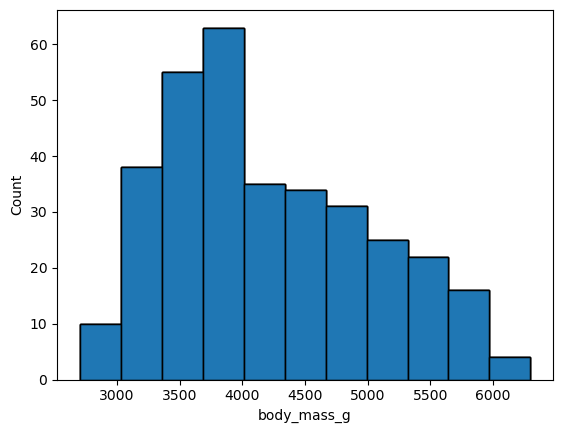

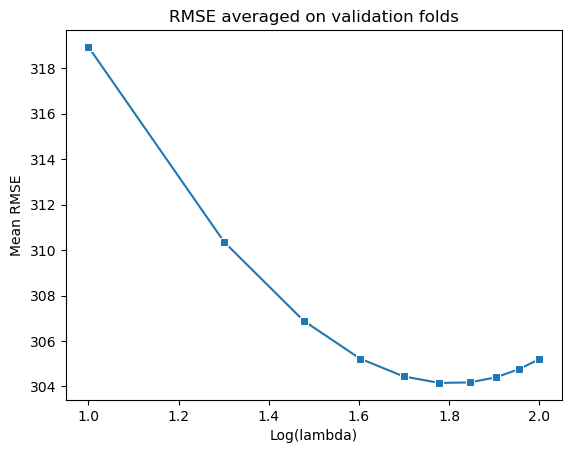

In [95]:
fig, ax = plt.subplots()
sns.lineplot(x = np.log10(alphas), y = cv_scores, marker = 's', ax = ax)
ax.set_xlabel('Log(lambda)')
ax.set_ylabel('Mean RMSE')
ax.set_title('RMSE averaged on validation folds')
plt.show()

Could fine tune:
- But of hyperparameter values tried $\lambda = 100$ is best.

Now we *finally* report results on the true test set:
- We have not fit optimized on it.
- Have not tuned hyperparameters to see how well it performs on validation folds.

**Test/hold-out set is our true final gold standard**

In [105]:
rr = Ridge(alpha = 100, random_state = 42)
rr.fit(X_train_processed, y_train)

Ridge(alpha=100, random_state=42)

In [106]:
y_pred = rr.predict(X_test_processed)

In [107]:
from sklearn.metrics import mean_squared_error
ridge_RMSE_holdout = np.sqrt(mean_squared_error(y_pred, y_test))
ridge_RMSE_holdout

265.4422590836656

Given the scale of the penguin body mass (g): this is good.

In [108]:
sns.histplot(y);

#### Takeaways of what we just did

- Polynomial model: poor prediction performance.
- L2 regularized the polynomial regression model (Ridge regression) + tuning
- **Much** better test performance than unregularized polynomial model.

But:
    
- Our simple linear model with no polynomial worked well.
- Almost as well as polynomial features
- Think carefully before adding model complexity.

A simple model with less number of good quality predictive features may work as well if not better.

Logical extension:
- Features that are correlated but don't want to throw them away.
- L2 regularized linear model + tuning:
    - don't throw out features.
    - get better test performance than OLS by reducing weight variance.


Sometimes though: throwing away features might work better:
- Learn good features only with high predictive power
- Chuck the rest.

#### L1 Regularization (LASSO)

$$ L = ||{y} - X {w}||_2^2 + \lambda ||{w}||_1 $$

with $||{w}||_1 = |w_1| + |w_2| + ... + |w_m|$ as sum of absolute magnitude of the feature weights.

Taxi cab vs Euclidean distance:

<img src = "Images/metrics.png" width = 450/>

Circle in terms of L2 vs L1 distance:

"Circle" in L1:
<img src = "Images/taxcabgeometry.jpg" width = 400/>

"Circles" for different metrics

<img src = "Images/circles.png" width = 400/>

Why use the L1 magnitude $||{w}||_1$ for regularization?

LASSO encourages model weight sparsity: 
- prefers to drive weights $w_i$ for features with little predictive power to 0.

<img src = "Images/different_metric_regularization.png" width = 600 />

Perform LASSO regression with scikit-learn:

In [96]:
from sklearn.linear_model import Lasso

Find the best LASSO model: tune regularization hyperparameter.

In [97]:
alphas = [1, 10, 100, 1e3, 1e4]
cv_lasso_scores = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter = 10000)
    cv_loop_results = cross_validate(
                X=X_train_processed, 
                y=y_train,
                estimator=lasso, 
                cv=10,
                scoring=('neg_mean_squared_error'))
    cv_lasso_scores.append(np.mean(np.sqrt(np.abs(cv_loop_results['test_score']))))

In [98]:
alphas

[1, 10, 100, 1000.0, 10000.0]

In [99]:
cv_lasso_scores

[344.87684564435705,
 301.76131575156904,
 340.26932591239273,
 699.4512087784858,
 811.3632576452586]

The best LASSO model:

In [100]:
lasso_opt = Lasso(alpha=10, random_state=42,  max_iter = 100000)
lasso_opt.fit(X_train_processed, y_train)

y_pred = lasso_opt.predict(X_test_processed) # get final test prediction

In [101]:
lasso_RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
lasso_RMSE

267.3764555465847

In [102]:
ridge_RMSE_holdout

267.0898692792426

Comparable between ridge and LASSO. LASSO tends to have higher weight variance than ridge.

But what's the real difference?

In [109]:
print(rr.coef_)

[  0.          29.32960231   0.8046896   38.17109867  -4.10436699
  40.27228066 -10.86847643  -1.58292157  37.48222572 -14.02382992
  -4.57236431  -5.95361058 -20.50428693  -0.75058332 -24.04661014
 -10.05361186 -10.79395713 -10.65313696  -1.72724584   5.1723557
 -14.20925988   5.06212976  -0.25055749 -17.27288405   0.57708637
 -16.2812928    7.40733877 -20.38843876 -19.91851821   4.7657019
  -5.75859125 -17.85396187   0.47018371   2.37087442 -22.65473387
  23.22926662 -23.72344945 -13.9956209   -3.80574878  -5.11166274
   5.35232607  -8.82144444  -3.60074121  -9.27420928  -2.71133015
  -4.99539005   4.03028956   9.62441097   1.62602145  17.78209921
  10.12563598  12.69525486  16.44364281  14.71106968  13.32988964
   4.32024456  -9.68390238   5.32047154  -0.74803361   1.05694406
  -7.35649966  23.17919449  10.28762348  20.77489205   9.9559688
  13.05856002   0.56126663   4.34217579   5.87326338   7.20871856
   6.7571956   28.89666184   1.20704504  -0.47418842  25.29255039
  18.01999863

In [104]:
lasso_opt.coef_

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -2.69391521e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -5.10132627e+01,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.47906338e+01,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

## The Strategy Behind Ridge / Lasso / Elastic Net

Overfit models overestimate the relevance that predictors have for a target. Thus overfit models tend to have **overly large coefficients**. 

Generally, overfitting models come from a result of high model variance. High model variance can be caused by:

- having irrelevant or too many predictors
- multicollinearity
- large coefficients

#### Ridge 
When we introduce many features that:
- we believe may all have some predictive power.
- want to heavily penalize weight variance

#### LASSO

We have dataset with many highly correlated features:
- believe many are not actually adding to predictive power.
- willing to cut away marginally unimportant features.


Which is better:
- depends on dataset
- modeling goal 

### LEVEL UP - Elastic Net!
Naturally, the Elastic Net has the same interface through sklearn as the other regularization tools! The only difference is that we now have to specify how much of each regularization term we want. The name of the parameter for this (represented by $\rho$ above) in sklearn is `l1_ratio`.

In [110]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=10, l1_ratio=0.1, random_state=42)

enet.fit(X_train_processed, y_train)

ElasticNet(alpha=10, l1_ratio=0.1, random_state=42)

In [111]:
enet.score(X_train_processed, y_train)

0.7967984860498589

In [112]:
enet.score(X_test_processed, y_test)

0.8341204160263829

Setting the `l1_ratio` to 1 is equivalent to the lasso:

In [113]:
ratios = np.linspace(0.01, 1, 100)

In [114]:
preds = []
for ratio in ratios:
    enet = ElasticNet(alpha=100, l1_ratio=ratio, random_state=42)
    enet.fit(X_train_processed, y_train)
    preds.append(enet.predict(X_test_processed[0].reshape(1, -1)))

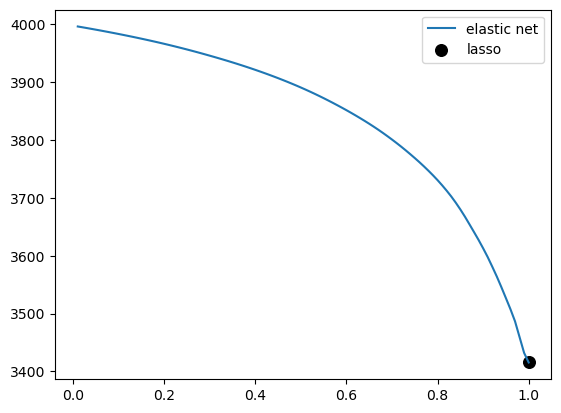

In [119]:
fig, ax = plt.subplots()

lasso = Lasso(alpha=100, random_state=42)
lasso.fit(X_train_processed, y_train)
lasso_pred = lasso.predict(X_test_processed[0].reshape(1, -1))

ax.plot(ratios, preds, label='elastic net')
ax.scatter(1, lasso_pred, c='k', s=70, label='lasso')
plt.legend()
plt.show();

#### Note on `ElasticNet()`
Is an Elastic Net with `l1_ratio` set to 0 equivalent to the ridge? In theory yes. But in practice no. It looks like the `ElasticNet()` predictions on the first test data point as `l1_ratio` shrinks are tending toward some value around 3400. Let's check to see what prediction `Ridge()` gives us:

In [116]:
ridge = Ridge(alpha=10, random_state=42)
ridge.fit(X_train_processed, y_train)
ridge.predict(X_test_processed[0].reshape(1, -1))[0]

3092.74210752218

If you check the docstring for the `ElasticNet()` class you will see:
- that the function being minimized is slightly different from what we saw above; and
- that the results are unreliable when `l1_ratio` $\leq 0.01$.

**Exercise**: Visualize the difference in this case between `ElasticNet(l1_ratio=0.01)` and `Ridge()` by making a scatterplot of each model's predicted values for the first ten points in `X_test_processed`. Use `alpha=10` for each model.

        Level Up: Make a second scatterplot that compares the predictions on the same data
        points between ElasticNet(l1_ratio=1) and Lasso().

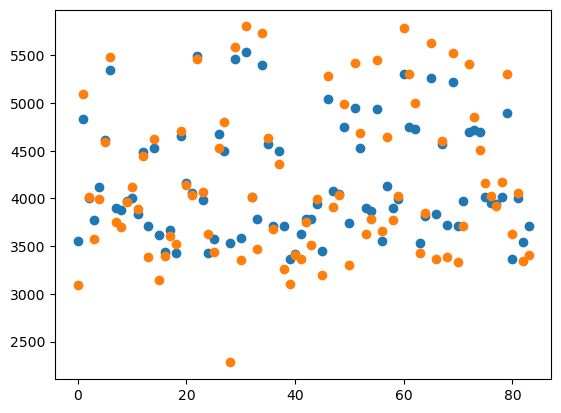

In [132]:
fig, ax = plt.subplots()
enet_r = ElasticNet(alpha=10, l1_ratio=0.01, random_state=42)
enet_r.fit(X_train_processed, y_train)
preds_enr = enet_r.predict(X_test_processed[:84])
preds_ridge = ridge.predict(X_test_processed[:84])
ax.scatter(np.arange(84), preds_enr)
ax.scatter(np.arange(84), preds_ridge)
plt.show()

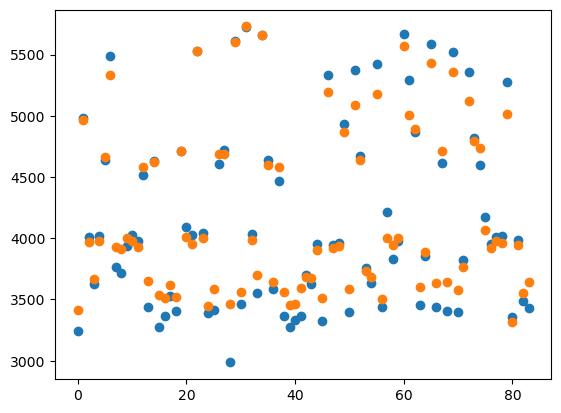

In [128]:
fig, ax = plt.subplots()
enet_l = ElasticNet(alpha=10, l1_ratio=1, random_state=42)
enet_l.fit(X_train_processed, y_train)
preds_enl = enet_l.predict(X_test_processed[:84])
preds_lasso = lasso.predict(X_test_processed[:84])
ax.scatter(np.arange(84), preds_enl)
ax.scatter(np.arange(84), preds_lasso)
plt.show()

In [133]:
len(preds_enr)

84

<details>
    <summary>
        Level Up Answer
    </summary>
<code>fig, ax = plt.subplots()
enet_l = ElasticNet(alpha=10, l1_ratio=1, random_state=42)
enet_l.fit(X_train_processed, y_train)
preds_enl = enet_l.predict(X_test_processed[:10])
preds_lasso = lasso.predict(X_test_processed[:10])
ax.scatter(np.arange(10), preds_enl)
ax.scatter(np.arange(10), preds_lasso);</code>
    </details

#### Fitting Regularized Models with Cross-Validation
Our friend `sklearn` also includes tools that fit regularized regressions *with cross-validation*: `LassoCV`, `RidgeCV`, and `ElasticNetCV`.


**Exercise**: Use `RidgeCV` to fit a seven-fold cross-validated ridge regression model to our `X_train_processed` data and then calculate $R^2$ and the RMSE (root-mean-squared error) on our test set.


<details>
    <summary>
        Answer
    </summary>
    <code>rcv = RidgeCV(cv=7)
rcv.fit(X_train_processed, y_train)
rcv.score(X_test_processed, y_test)
np.sqrt(mean_squared_error(y_test, rcv.predict(X_test_processed)))</code>
    </details>

## Level Up Exercise: Name that Model!

Consider the following scenarios and describe them according to bias and variance. There are four possibilities:

- a. The model has low bias and high variance.
- b. The model has high bias and low variance.
- c. The model has both low bias and low variance.
- d. The model has both high bias and high variance.

**Scenario 1**: The model has a low RMSE on training and a low RMSE on test.
<details>
    <summary> Answer
    </summary>
    c. The model has both low bias and low variance.
    </details>

**Scenario 2**: The model has a high $R^2$ on the training set, but a low $R^2$ on the test.
<details>
    <summary> Answer
    </summary>
    a. The model has low bias and high variance.
    </details>

**Scenario 3**: The model performs well on data it is fit on and well on data it has not seen.
<details>
    <summary> Answer
    </summary>
    c. The model has both low bias and low variance.
    </details>
  

**Scenario 4**: The model has a low $R^2$ on training but high on the test set.
<details>
    <summary> Answer
    </summary>
    d. The model has both high bias and high variance.
    </details>

**Scenario 5**: The model leaves out many of the meaningful predictors, but is consistent across samples.
<details>
    <summary> Answer
    </summary>
    b. The model has high bias and low variance.
    </details>

**Scenario 6**: The model is highly sensitive to random noise in the training set.
<details>
    <summary> Answer
    </summary>
    a. The model has low bias and high variance.
    </details>